# GA DSI 26: Project 3 - Reddit Subreddits Classification
***

## Notebook organisation
- Notebook 1: Introduction, Web scraping and Data Acquisition
- Notebook 2: EDA and Pre-Processing
- **Notebook 3: Model Preparation, Tuning, Insights and Conclusion (current notebook)**

***

In this notebook, the cleaned and pre-processed data from Notebook 2 will be imported to train and evaluate a model that can help classify new enquires for my company into the categories of PC building or tech support. I am using the posts in r/buildapc and r/techsupport subreddits as a proxy database pf enquries posts to train the model. 


## Import libraries and data

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from wordcloud import WordCloud
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import data from Notebook 2

buildapc = pd.read_csv('../datasets/buildapc_processed.csv')
techsupport = pd.read_csv('../datasets/techsupport_processed.csv')

In [3]:
buildapc.head()

,subreddit,text_tokens
0,buildapc,or xt So gonna be building gaming PC for gamin...
1,buildapc,Upgrading to p144Hz setup would like some fina...
2,buildapc,Help fine tune my build before it final My bui...
3,buildapc,Need help picking out KVM or other solution to...
4,buildapc,Ryzen GT or Ryzen Hello So unfortunately my ol...


In [4]:
buildapc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    976 non-null    object
 1   text_tokens  976 non-null    object
dtypes: object(2)
memory usage: 15.4+ KB


In [5]:
techsupport.head()

,subreddit,text_tokens
0,techsupport,Win dwm exe is using way too much vram have be...
1,techsupport,Toshiba Qosmio X70B10T graphics card not detec...
2,techsupport,How to find original MD5 Hash Hello am trying ...
3,techsupport,Is it worth upgrading to Windows for mostly ga...
4,techsupport,Deleted google tv remote can control tv was ha...


In [6]:
techsupport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    932 non-null    object
 1   text_tokens  932 non-null    object
dtypes: object(2)
memory usage: 14.7+ KB


## Prepare the data for modeling

I will be merging the two dataframes into a single dataframe and encoding the subreddit column.

The classes are as follow:
- **r/buildapc will be 0**
- **r/techsupport will be 1**

### Merging dataframes and encoding the `'subreddit'` column

I will be merging the r/buildapc and r/techsupport dataframes into a single dataframe for modeling and to encode the `'subreddit'` column according to the class specified above.


In [7]:
# merging of the dataframes into a single dataframe
merged = pd.concat([buildapc, techsupport])
merged.reset_index(drop = True, inplace = True)
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    1908 non-null   object
 1   text_tokens  1908 non-null   object
dtypes: object(2)
memory usage: 29.9+ KB


In [8]:
# check the top 5 rows
merged.head()

,subreddit,text_tokens
0,buildapc,or xt So gonna be building gaming PC for gamin...
1,buildapc,Upgrading to p144Hz setup would like some fina...
2,buildapc,Help fine tune my build before it final My bui...
3,buildapc,Need help picking out KVM or other solution to...
4,buildapc,Ryzen GT or Ryzen Hello So unfortunately my ol...


In [9]:
# check the last 5 rows to ensure the merging was done successfully. 
merged.tail()

,subreddit,text_tokens
1903,techsupport,help with windows recovery windows need help w...
1904,techsupport,Xbox Adapter not working Help plugged in Realt...
1905,techsupport,Unable to install windows store ubuntu apps er...
1906,techsupport,PC making this strange noise cant for the life...
1907,techsupport,Extremely Slow Nitro Windows H2 Seagate Cuda H...


In [10]:
# encoding the subreddit column
merged['subreddit'] = merged['subreddit'].map({'buildapc' : 0, 'techsupport' : 1})

In [11]:
# check the first 5 rows
merged.head()

,subreddit,text_tokens
0,0,or xt So gonna be building gaming PC for gamin...
1,0,Upgrading to p144Hz setup would like some fina...
2,0,Help fine tune my build before it final My bui...
3,0,Need help picking out KVM or other solution to...
4,0,Ryzen GT or Ryzen Hello So unfortunately my ol...


In [12]:
# check the last 5 rows to ensure encoding is done correctly.
merged.tail()

,subreddit,text_tokens
1903,1,help with windows recovery windows need help w...
1904,1,Xbox Adapter not working Help plugged in Realt...
1905,1,Unable to install windows store ubuntu apps er...
1906,1,PC making this strange noise cant for the life...
1907,1,Extremely Slow Nitro Windows H2 Seagate Cuda H...


### Check for class balance

We will need to check for unbalanced class in our data and it can be seen that the data is rather balance with r/buildapc having slightly more posts compared to r/techsupport. Imbalanced class would be an issue as it could skew the model and affect the classification model. In our data, the classes are pretty much even and there should be no such issue. 

In [13]:
merged['subreddit'].value_counts(normalize = True)

0    0.51153
1    0.48847
Name: subreddit, dtype: float64

### Get the X and y data

The target variable is the `'subreddit'` column hence that would be the y variable and the `'text_tokens'` column would be the X variable. 

In [14]:
# get the data
X = merged['text_tokens']
y = merged['subreddit']

In [15]:
X.head()

0    or xt So gonna be building gaming PC for gamin...
1    Upgrading to p144Hz setup would like some fina...
2    Help fine tune my build before it final My bui...
3    Need help picking out KVM or other solution to...
4    Ryzen GT or Ryzen Hello So unfortunately my ol...
Name: text_tokens, dtype: object

### Train, test, split the data

As we have a good size dataset of 1908 rows, I would allocate 80% of the data for training and the remaining 20% for testing to ensure the model has the largest possible set of data to train on. 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1526,)
(382,)
(1526,)
(382,)


### Additional Stopwords

This list is copied from Notebook 2. 

In [18]:
# default stop words list
stop_words_set = set(stopwords.words('english'))

# add additional stopwords
additional_stopwords = {'build', 'building', 'pc', ' computer', 'computers', 'tech', 'technology',\
                        'support', 'supporting', 'thanks', 'thank','appreciated', 'appreciate', 'appreciates',\
                       'help'}

stop_words_set = stop_words_set.union(additional_stopwords)

### Custom Functions

In [19]:
def plot_cm(model, X_test = X_test, y_test = y_test):
    """Function to plot confusion matrix and get all the classification metrics scores"""
    # get y_pred value
    y_pred = model.predict(X_test)
    
    # get confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Plot confusion matrix
    plot_confusion_matrix(model, X_test, y_test, cmap = 'GnBu', values_format = 'd')

    print("Classification Performance Metrics")   
    # accuracy
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    print('Accuracy   :', round(accuracy, 4))

In [20]:
def print_model_scores(model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    """Function to print the model train, test, best scores and best params"""
    print("Model train score:", round(model.score(X_train, y_train), 3))
    print("Model test score:", round(model.score(X_test, y_test), 3))
    print("Model best score:", round(model.best_score_, 3))
    print("Model best params:", model.best_params_)

## Model Testing and Hyperparameters Testing
***

I will be testing 2 vectorizer with 3 classifier which gives a total of 6 models:
- CountVectorizer with Multinomial Naive Bayes
- TfidfVectorizer with Multinomial Naive Bayes
- CountVectorizer with Random Forest
- TfidfVectorizer with Random Forest
- CountVectorizer with Logistic Regression
- TfidfVectorizer with Logistic Regression

For the classification metric to be used, it will be **accuracy** which is a measure of the proportion of true predictions over all predictions. This is relevant to our case here as either false positive or false negative are equally bad as we want to accurately classify all incoming queries to the correct category. 

In the model testing and Hyperparameters tuning, I will be using GridSearchCV to go over several parameters for the various models to come up with the best model within the parameters. If there are issues with the scores, the parameters will be tweaked and the GridSearchCV will be run again to test the new parameters. 

### Baseline Accuracy
***
This would be the baseline accuracy score to check if the model is performing better than the null model.

In [21]:
# baseline training score
round(y_train.value_counts(normalize = True), 3)

0    0.512
1    0.488
Name: subreddit, dtype: float64

In [22]:
# baseline testing score
round(y_test.value_counts(normalize = True), 3)

0    0.51
1    0.49
Name: subreddit, dtype: float64

### Model 1: CountVectorizer with Multinomial Naive Bayes
***

In [23]:
# Set up pipeline for CountVectorizer with Multinomial Naive Bayes

pipe_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

#### Hyper Parameter Tuning using GridSearchCV 

In [24]:
# Run 1
pipe_nb_params = {
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__stop_words' : [stop_words_set],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 2), (2, 3), (1, 3)],
    'nb__fit_prior' : [True, False]
}

In [25]:
%%time 
# GridSearch for Run 1

gs_nb = GridSearchCV(pipe_nb, param_grid = pipe_nb_params, cv = 5, n_jobs = 2, scoring = 'accuracy', verbose = 1)
gs_nb.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 1min 10s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=2,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 2), (2, 3), (1, 3)],
                         'cvec__stop_words': [{' computer', 'a', 'about',
                                               'above', 'after', 'again',
                                               'against', 'ain', 'all', 'am',
                                               'an', 'and', 'any', 'appreciate',
                                               'appreciated', 'appreciates',
                                               'are', 'aren', "aren't", 'as',
                                               'at', 'be', 'because', 'been',
                                          

#### Results for CountVectorizer with Multinomial Naive Bayes Model

In [26]:
print_model_scores(gs_nb)

Model train score: 0.883
Model test score: 0.859
Model best score: 0.837
Model best params: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': {"weren't", "needn't", 'then', 'the', 'through', 'up', 'same', 'does', 'at', 'again', 'for', 'you', "won't", 'below', 'under', 'over', 'mustn', 'these', "you'd", 'into', 'she', 'thanks', 'yourself', 'other', 'or', 'he', 'against', 'do', 'above', 'am', "hasn't", 'shouldn', 'its', 'needn', 'isn', 'did', 'not', 'himself', 'those', 'should', 'now', 'too', 'building', 'him', 'build', 'than', 'm', "she's", 'tech', 'with', 'that', "shan't", 'are', 'out', 're', 'couldn', 'we', 'itself', 'own', 'each', 'before', 's', 'ourselves', 'as', 'where', 'by', 'is', 'were', 'which', 'during', "couldn't", "haven't", 'thank', 'an', 'theirs', 'doing', 'in', 'computers', 'further', 'what', 'has', 'so', 'shan', 'why', 'myself', 'pc', 'appreciates', 'been', 'be', 'your', 'once', 't', 'of', 'about', 'nor'

#### Getting the Top 30 words which affect the classification model

In [27]:
gs_nb.best_estimator_['nb'].feature_log_prob_[0]

array([ -9.14802161,  -9.55348672,  -9.55348672, ...,  -9.84116879,
       -10.93978108,  -8.23173088])

In [28]:
# find the log probability of both class 0 and class 1
zero_class_prob = gs_nb.best_estimator_['nb'].feature_log_prob_[0, :]
one_class_prob = gs_nb.best_estimator_['nb'].feature_log_prob_[1, :]
nb_prob = one_class_prob - zero_class_prob

# get corresponding feature names
names = gs_nb.best_estimator_['cvec'].get_feature_names()

# creating dataframes
nb_prob_df = pd.DataFrame(nb_prob, index = names, columns = ['coef'])


In [29]:
# Creating 'abs_coef' column

nb_prob_df['abs_coef'] = abs(nb_prob_df['coef'])
nb_prob_df_plot = nb_prob_df.sort_values(ascending = False, by = 'abs_coef').head(30)
nb_prob_df_plot

,coef,abs_coef
atx,-4.087020,4.087020
part list,-4.024500,4.024500
planning,-3.957809,3.957809
price,-3.886350,3.886350
certified,-3.658566,3.658566
ghz core,-3.635035,3.635035
cfm,-3.610938,3.610938
mid tower,-3.586245,3.586245
atx power,-3.534952,3.534952
nvme solid,-3.534952,3.534952


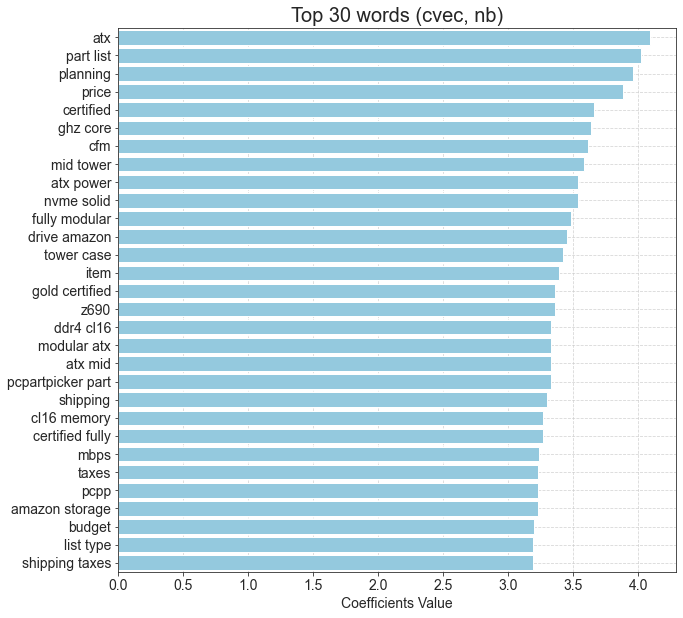

In [30]:
# plot barplot
plt.figure(figsize = (10,10))
sns.barplot(x = nb_prob_df_plot['abs_coef'],
            y = nb_prob_df_plot.index,
            color = 'skyblue')
plt.title('Top 30 words (cvec, nb)', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Coefficients Value', fontsize = 14)
plt.grid(linestyle = '--', alpha = 0.8);

The above top 30 words represent the words are important to the classification model sorted by the coefficients. 

#### Word Cloud for Top 30 words

This is just for visual representation.

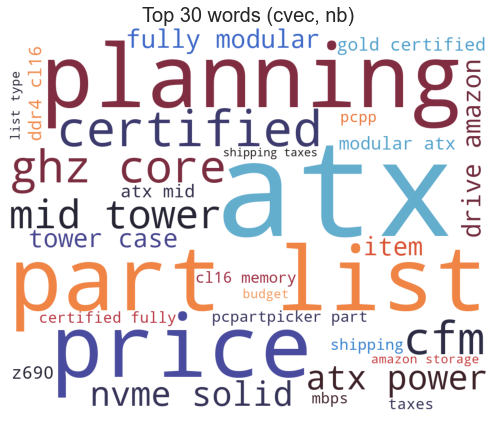

In [31]:
# plot word clouds
wc_nb = WordCloud(max_words= 30, 
                  width = 1000, 
                  height = 800, 
                  background_color = 'white',
                  colormap = 'icefire').generate_from_frequencies(nb_prob_df_plot['abs_coef'])

plt.figure(figsize = (7,7))

plt.imshow(wc_nb)
plt.axis('off')
plt.title('Top 30 words (cvec, nb)', fontsize = 20)

plt.tight_layout();

#### Confusion Matrix

The classes are as follow:
- **r/buildapc will be 0**
- **r/techsupport will be 1**

Classification Performance Metrics
Accuracy   : 0.8586


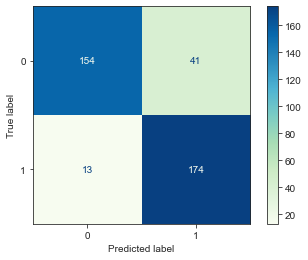

In [32]:
# plot confusion matrix for model 1
plot_cm(gs_nb)

- False positive: posts from r/buildapc are wrongly classified as from r/techsupport
- False negative: posts from r/techsupport are wrongly classified as from r/buildapc

As seen from the confusion matrix, there are more false positive counts than false negative counts where there are more posts from r/buildapc being wrongly classified as from r/techsupport. 

### Model 2: TfidfVectorizer with Multinomial Naive Bayes
***

In [33]:
# Set up pipeline for TfidfVectorizer with Multinomial Naive Bayes

pipe_tfnb = Pipeline([
    ('tf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

#### Hyper Parameter Tuning using GridSearchCV 

In [34]:
# Run 1
pipe_tfnb_params = {
    'tf__max_features': [3000, 4000, 5000],
    'tf__stop_words' : [stop_words_set],
    'tf__min_df': [2, 3],
    'tf__max_df': [.9, .95],
    'tf__ngram_range': [(1,2), (2,3)],
    'nb__fit_prior' : [True, False]
}

In [35]:
%%time
# GridSearch for Run 1

gs_tfnb = GridSearchCV(pipe_tfnb,
                       param_grid = pipe_tfnb_params,
                       cv = 5,
                       n_jobs = 2,
                       scoring = 'accuracy',
                       verbose = 1)

gs_tfnb.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Wall time: 40.9 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=2,
             param_grid={'nb__fit_prior': [True, False],
                         'tf__max_df': [0.9, 0.95],
                         'tf__max_features': [3000, 4000, 5000],
                         'tf__min_df': [2, 3],
                         'tf__ngram_range': [(1, 2), (2, 3)],
                         'tf__stop_words': [{' computer', 'a', 'about', 'above',
                                             'after', 'again', 'against', 'ain',
                                             'all', 'am', 'an', 'and', 'any',
                                             'appreciate', 'appreciated',
                                             'appreciates', 'are', 'aren',
                                             "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
       

#### Results for TfidfVectorizer with Multinomial Naive Bayes Model

In [36]:
print_model_scores(gs_tfnb)

Model train score: 0.877
Model test score: 0.869
Model best score: 0.845
Model best params: {'nb__fit_prior': True, 'tf__max_df': 0.9, 'tf__max_features': 3000, 'tf__min_df': 2, 'tf__ngram_range': (1, 2), 'tf__stop_words': {"weren't", "needn't", 'then', 'the', 'through', 'up', 'same', 'does', 'at', 'again', 'for', 'you', "won't", 'below', 'under', 'over', 'mustn', 'these', "you'd", 'into', 'she', 'thanks', 'yourself', 'other', 'or', 'he', 'against', 'do', 'above', 'am', "hasn't", 'shouldn', 'its', 'needn', 'isn', 'did', 'not', 'himself', 'those', 'should', 'now', 'too', 'building', 'him', 'build', 'than', 'm', "she's", 'tech', 'with', 'that', "shan't", 'are', 'out', 're', 'couldn', 'we', 'itself', 'own', 'each', 'before', 's', 'ourselves', 'as', 'where', 'by', 'is', 'were', 'which', 'during', "couldn't", "haven't", 'thank', 'an', 'theirs', 'doing', 'in', 'computers', 'further', 'what', 'has', 'so', 'shan', 'why', 'myself', 'pc', 'appreciates', 'been', 'be', 'your', 'once', 't', 'of', '

#### Getting the Top 30 words which affect the classification model

In [37]:
# find the log probability of both class 0 and class 1
zero_class_prob_tfnb = gs_tfnb.best_estimator_['nb'].feature_log_prob_[0, :]
one_class_prob_tfnb = gs_tfnb.best_estimator_['nb'].feature_log_prob_[1, :]
nb_prob_tfnb = one_class_prob_tfnb - zero_class_prob_tfnb

# get corresponding feature names
names_tfnb = gs_tfnb.best_estimator_['tf'].get_feature_names()

# creating dataframes
nb_prob_tfnb_df = pd.DataFrame(nb_prob_tfnb, index = names_tfnb, columns = ['coef'])


In [38]:
# Creating 'abs_coef' column

nb_prob_tfnb_df['abs_coef'] = abs(nb_prob_tfnb_df['coef'])
nb_prob_tfnb_df_plot = nb_prob_tfnb_df.sort_values(ascending = False, by = 'abs_coef').head(30)
nb_prob_tfnb_df_plot

,coef,abs_coef
phone,2.294528,2.294528
price,-2.212995,2.212995
budget,-2.167867,2.167867
atx,-2.075164,2.075164
file,2.043701,2.043701
google,1.979408,1.979408
router,1.951564,1.951564
cooler,-1.946394,1.946394
z690,-1.905358,1.905358
planning,-1.902180,1.902180


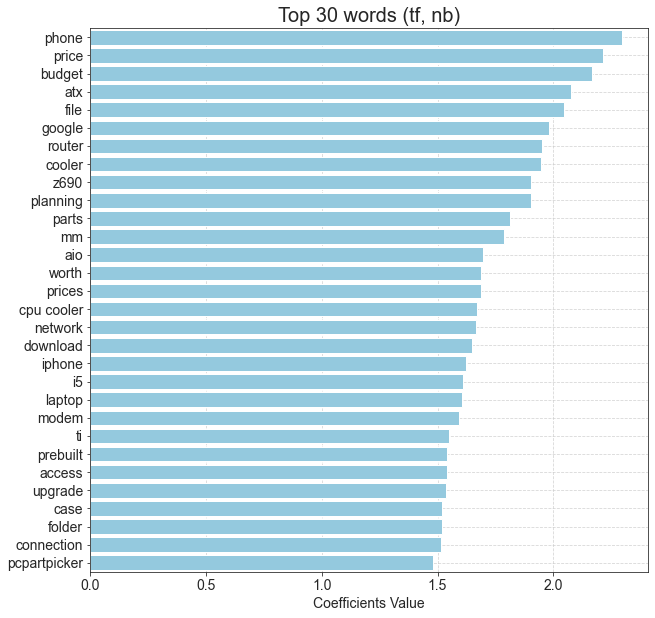

In [39]:
# plot barplot
plt.figure(figsize = (10,10))
sns.barplot(x = nb_prob_tfnb_df_plot['abs_coef'],
            y = nb_prob_tfnb_df_plot.index,
            color = 'skyblue')
plt.title('Top 30 words (tf, nb)', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Coefficients Value', fontsize = 14)
plt.grid(linestyle = '--', alpha = 0.8);

The above top 30 words represent the words are important to the classification model sorted by the coefficients. 

#### Word Cloud for Top 30 words

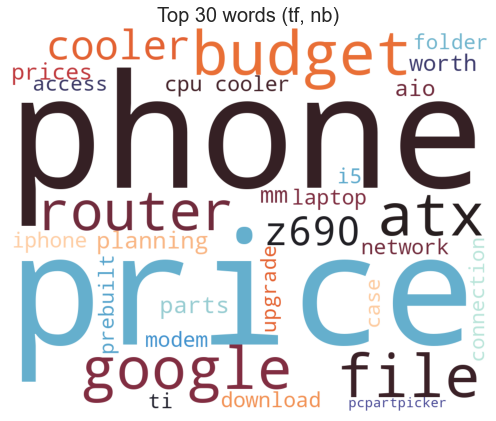

In [40]:
# plot word clouds
wc_tfnb = WordCloud(max_words= 30, 
                  width = 1000, 
                  height = 800, 
                  background_color = 'white',
                  colormap = 'icefire').generate_from_frequencies(nb_prob_tfnb_df_plot['abs_coef'])

plt.figure(figsize = (7,7))

plt.imshow(wc_tfnb)
plt.axis('off')
plt.title('Top 30 words (tf, nb)', fontsize = 20)

plt.tight_layout();

#### Confusion Matrix

- **r/buildapc will be 0**
- **r/techsupport will be 1**

Classification Performance Metrics
Accuracy   : 0.8691


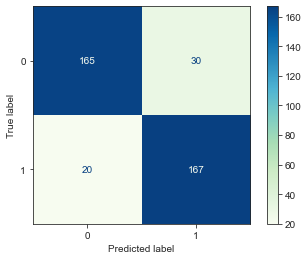

In [41]:
# plot confusion matrix for model 2
plot_cm(gs_tfnb)

- False positive: posts from r/buildapc are wrongly classified as from r/techsupport
- False negative: posts from r/techsupport are wrongly classified as from r/buildapc

As seen from the confusion matrix, there are slightly more false positive counts than false negative counts. 

### Model 3: CountVectorizer with Random Forest
***

In [42]:
pipe_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

#### Hyper Parameter Tuning using GridSearchCV

In [43]:
pipe_rf_params = {
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__stop_words' : [stop_words_set],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 2), (2, 3)],
    'rf__n_estimators' : [200, 300],
    'rf__max_depth': [3, 5],
    'rf__random_state' : [42]
}

In [44]:
%%time

gs_rf = GridSearchCV(pipe_rf,
                     param_grid = pipe_rf_params,
                     cv = 5,
                     n_jobs = 2,
                     scoring = 'accuracy',
                     verbose = 1)

gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Wall time: 2min 38s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=2,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 2), (2, 3)],
                         'cvec__stop_words': [{' computer', 'a', 'about',
                                               'above', 'after', 'again',
                                               'against', 'ain', 'all', 'am',
                                               'an', 'and', 'any', 'appreciate',
                                               'appreciated', 'appreciates',
                                               'are', 'aren', "aren't", 'as',
                                               'at', 'be', 'because', 'been',
                                         

#### Results for CountVectorizer with Random Forest Model

In [45]:
print_model_scores(gs_rf)

Model train score: 0.872
Model test score: 0.838
Model best score: 0.827
Model best params: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': {"weren't", "needn't", 'then', 'the', 'through', 'up', 'same', 'does', 'at', 'again', 'for', 'you', "won't", 'below', 'under', 'over', 'mustn', 'these', "you'd", 'into', 'she', 'thanks', 'yourself', 'other', 'or', 'he', 'against', 'do', 'above', 'am', "hasn't", 'shouldn', 'its', 'needn', 'isn', 'did', 'not', 'himself', 'those', 'should', 'now', 'too', 'building', 'him', 'build', 'than', 'm', "she's", 'tech', 'with', 'that', "shan't", 'are', 'out', 're', 'couldn', 'we', 'itself', 'own', 'each', 'before', 's', 'ourselves', 'as', 'where', 'by', 'is', 'were', 'which', 'during', "couldn't", "haven't", 'thank', 'an', 'theirs', 'doing', 'in', 'computers', 'further', 'what', 'has', 'so', 'shan', 'why', 'myself', 'pc', 'appreciates', 'been', 'be', 'your', 'once', 't', 'of', 'about', 'nor'

#### Getting the Top 30 words which affect the classification model

In [46]:
gs_rf_coef = gs_rf.best_estimator_['rf'].feature_importances_
gs_rf_coef_names = gs_rf.best_estimator_['cvec'].get_feature_names()
gs_rf_df = pd.DataFrame(gs_rf_coef, index = gs_rf_coef_names, columns = ['coef'])
gs_rf_df.sort_values(ascending = False, by = ['coef']).head(30)

,coef
tried,0.033305
case,0.024442
laptop,0.023493
price,0.023087
issue,0.017371
windows,0.015832
motherboard,0.013758
budget,0.013619
cooler,0.013358
gb,0.013185


#### Word Cloud for Top 30 words

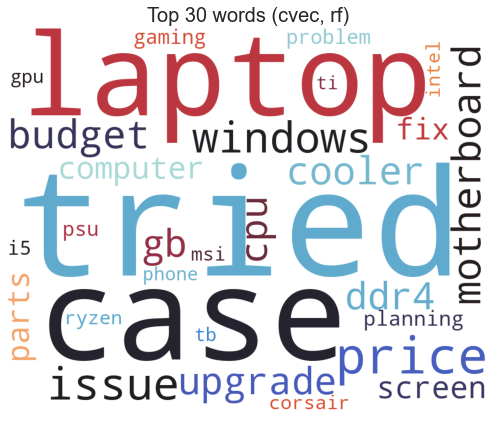

In [47]:
# plot word clouds
wc_rf = WordCloud(max_words= 30, 
                  width = 1000, 
                  height = 800, 
                  background_color = 'white',
                  colormap = 'icefire').generate_from_frequencies(gs_rf_df['coef'])

plt.figure(figsize = (7,7))

plt.imshow(wc_rf)
plt.axis('off')
plt.title('Top 30 words (cvec, rf)', fontsize = 20)

plt.tight_layout();

#### Confusion Matrix

- **r/buildapc will be 0**
- **r/techsupport will be 1**

Classification Performance Metrics
Accuracy   : 0.8377


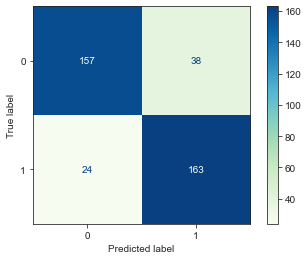

In [48]:
# plot confusion matrix of model 3
plot_cm(gs_rf)

- False positive: posts from r/buildapc are wrongly classified as from r/techsupport
- False negative: posts from r/techsupport are wrongly classified as from r/buildapc

As seen from the confusion matrix, there are slightly more false positive counts than false negative counts. 

### Model 4: TfidfVectorizer with Random Forest
***

In [49]:
pipe_tfrf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

#### Hyper Parameter Tuning using GridSearchCV

In [50]:
pipe_tfrf_params = {
    'tf__max_features': [3000, 4000, 5000],
    'tf__stop_words' : [stop_words_set],
    'tf__min_df': [2, 3],
    'tf__max_df': [.9, .95],
    'tf__ngram_range': [(1,2), (2,3)],
    'rf__n_estimators' : [200, 300],
    'rf__max_depth': [3, 5],
    'rf__random_state' : [42]
}

In [51]:
%%time
# GridSearch 
gs_tfrf = GridSearchCV(pipe_tfrf,
                       param_grid = pipe_tfrf_params,
                       cv = 5,
                       n_jobs = 2,
                       scoring = 'accuracy',
                       verbose = 1)

gs_tfrf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Wall time: 2min 36s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=2,
             param_grid={'rf__max_depth': [3, 5],
                         'rf__n_estimators': [200, 300],
                         'rf__random_state': [42], 'tf__max_df': [0.9, 0.95],
                         'tf__max_features': [3000, 4000, 5000],
                         'tf__min_df': [2, 3],
                         'tf__ngram_range': [(1, 2), (2, 3)],
                         'tf__stop_words': [{' computer', 'a', 'about', 'above',
                                             'after', 'again', 'against', 'ain',
                                             'all', 'am', 'an', 'and', 'any',
                                             'appreciate', 'appreciated',
                                             'appreciates', 'are', 'aren',
                                             "aren't", 'as', 'at', 'b

#### Results for TfidfVectorizer with Random Forest Model

In [52]:
print_model_scores(gs_tfrf)

Model train score: 0.883
Model test score: 0.832
Model best score: 0.822
Model best params: {'rf__max_depth': 5, 'rf__n_estimators': 300, 'rf__random_state': 42, 'tf__max_df': 0.9, 'tf__max_features': 3000, 'tf__min_df': 2, 'tf__ngram_range': (1, 2), 'tf__stop_words': {"weren't", "needn't", 'then', 'the', 'through', 'up', 'same', 'does', 'at', 'again', 'for', 'you', "won't", 'below', 'under', 'over', 'mustn', 'these', "you'd", 'into', 'she', 'thanks', 'yourself', 'other', 'or', 'he', 'against', 'do', 'above', 'am', "hasn't", 'shouldn', 'its', 'needn', 'isn', 'did', 'not', 'himself', 'those', 'should', 'now', 'too', 'building', 'him', 'build', 'than', 'm', "she's", 'tech', 'with', 'that', "shan't", 'are', 'out', 're', 'couldn', 'we', 'itself', 'own', 'each', 'before', 's', 'ourselves', 'as', 'where', 'by', 'is', 'were', 'which', 'during', "couldn't", "haven't", 'thank', 'an', 'theirs', 'doing', 'in', 'computers', 'further', 'what', 'has', 'so', 'shan', 'why', 'myself', 'pc', 'appreciate

#### Getting the Top 30 words which affect the classification model

In [53]:
gs_tfrf_coef = gs_tfrf.best_estimator_['rf'].feature_importances_
gs_tfrf_coef_names = gs_tfrf.best_estimator_['tf'].get_feature_names()
gs_tfrf_df = pd.DataFrame(gs_tfrf_coef, index = gs_tfrf_coef_names, columns = ['coef'])
gs_tfrf_df.sort_values(ascending = False, by = ['coef']).head(30)

,coef
cpu,0.027139
laptop,0.024524
case,0.023489
tried,0.020982
cooler,0.019218
windows,0.018708
fix,0.018585
gb,0.018198
issue,0.017998
budget,0.017381


#### Word Cloud for Top 30 words

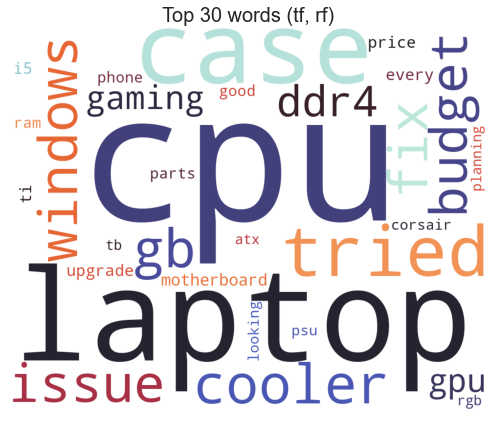

In [54]:
# plot word clouds
wc_rf1 = WordCloud(max_words= 30, 
                  width = 1000, 
                  height = 800, 
                  background_color = 'white',
                  colormap = 'icefire').generate_from_frequencies(gs_tfrf_df['coef'])

plt.figure(figsize = (7,7))

plt.imshow(wc_rf1)
plt.axis('off')
plt.title('Top 30 words (tf, rf)', fontsize = 20)

plt.tight_layout();

#### Confusion Matrix

- **r/buildapc will be 0**
- **r/techsupport will be 1**

Classification Performance Metrics
Accuracy   : 0.8325


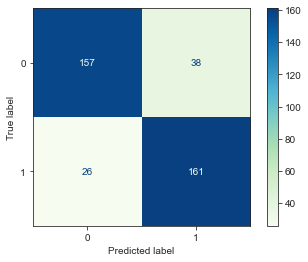

In [55]:
plot_cm(gs_tfrf)

- False positive: posts from r/buildapc are wrongly classified as from r/techsupport
- False negative: posts from r/techsupport are wrongly classified as from r/buildapc

As seen from the confusion matrix, there are slightly more false positive counts than false negative counts. 

### Model 5: CountVectorizer with Logistic Regression
***

In [56]:
pipe_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

#### Hyper Parameter Tuning using GridSearchCV

In [57]:
pipe_lr_params = {
    'cvec__max_features': [2000, 2500, 3000],
    'cvec__stop_words' : [stop_words_set],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 2), (2, 3)],
    'lr__C': [0.3, 0.1],
    'lr__max_iter': [100, 200]
}

I noticed overfitting during some of the runs and have tuned the C value to smaller value to reduce overfitting. A low C value tells the model to give more weight to this complexity penalty at the expense of fitting to the training data. The max features in the CountVectorizer have also been lower (from 5000 to 3000) to attempt to reduce overfitting, however it is still very overfitted. 

In [58]:
%%time
# GridSearch 
gs_lr = GridSearchCV(pipe_lr,
                     param_grid = pipe_lr_params,
                     cv = 5,
                     n_jobs = 2,
                     scoring = 'accuracy',
                     verbose = 1)

gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Wall time: 1min 23s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=2,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 2500, 3000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 2), (2, 3)],
                         'cvec__stop_words': [{' computer', 'a', 'about',
                                               'above', 'after', 'again',
                                               'against', 'ain', 'all', 'am',
                                               'an', 'and', 'any', 'appreciate',
                                               'appreciated', 'appreciates',
                                               'are', 'aren', "aren't", 'as',
                                               'at', 'be', 'because', 'been',
                                             

#### Results for CountVectorizer with Logistic Regression Model

In [59]:
print_model_scores(gs_lr)

Model train score: 0.962
Model test score: 0.827
Model best score: 0.815
Model best params: {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': {"weren't", "needn't", 'then', 'the', 'through', 'up', 'same', 'does', 'at', 'again', 'for', 'you', "won't", 'below', 'under', 'over', 'mustn', 'these', "you'd", 'into', 'she', 'thanks', 'yourself', 'other', 'or', 'he', 'against', 'do', 'above', 'am', "hasn't", 'shouldn', 'its', 'needn', 'isn', 'did', 'not', 'himself', 'those', 'should', 'now', 'too', 'building', 'him', 'build', 'than', 'm', "she's", 'tech', 'with', 'that', "shan't", 'are', 'out', 're', 'couldn', 'we', 'itself', 'own', 'each', 'before', 's', 'ourselves', 'as', 'where', 'by', 'is', 'were', 'which', 'during', "couldn't", "haven't", 'thank', 'an', 'theirs', 'doing', 'in', 'computers', 'further', 'what', 'has', 'so', 'shan', 'why', 'myself', 'pc', 'appreciates', 'been', 'be', 'your', 'once', 't', 'of', 'about', 'nor'

The results for this model shows that the model is very overfitted as shown from the difference in the train and test score. This could be due to the way that CountVectorizer vectorizing the words without looking at the importance of the words in relation to the entire corpus.

#### Getting the Top 30 words which affect the classification model

In [60]:
lr_coef = gs_lr.best_estimator_['lr'].coef_[0]
lr_names = gs_lr.best_estimator_['cvec'].get_feature_names()
lr_coef_df = pd.DataFrame(lr_coef, index = lr_names, columns = ['coef'])
lr_coef_df['abs_coef'] = abs(lr_coef_df['coef'])
lr_coef_plot = lr_coef_df.sort_values(ascending = False, by = 'abs_coef').head(30)
lr_coef_plot

,coef,abs_coef
laptop,0.598527,0.598527
google,0.481796,0.481796
phone,0.474524,0.474524
problem,0.460670,0.460670
issue,0.458352,0.458352
z690,-0.439466,0.439466
best,-0.434491,0.434491
parts,-0.423916,0.423916
thing,0.414536,0.414536
price,-0.402589,0.402589


LR Coef explanation
coef_ is of shape (1, n_features) when the given problem is binary. In particular, when multi_class='multinomial', coef_ corresponds to outcome 1 (True) and -coef_ corresponds to outcome 0 (False).

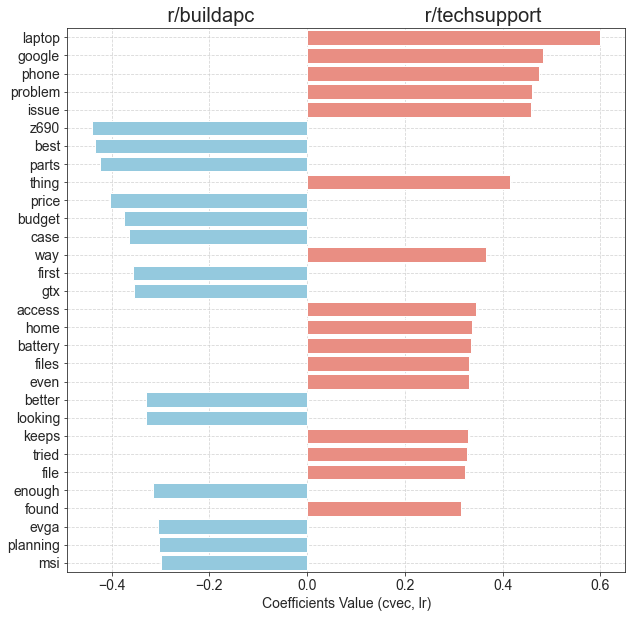

In [61]:
# define a list of colour according to positive or negative values
color_lst = ['skyblue' if float(x) < 0  else 'salmon' for x in lr_coef_plot['coef']]

# plot barplot
plt.figure(figsize = (10,10))
sns.barplot(x = lr_coef_plot['coef'],
            y = lr_coef_plot.index,
            palette = color_lst)
plt.title('   r/buildapc                               r/techsupport', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Coefficients Value (cvec, lr)', fontsize = 14)
plt.grid(linestyle = '--', alpha = 0.8);

For the Logisitic Regression coefficients of the top 30 features, it can be seen from the above bar chart for the features in blue correspond to class 0 (r/buildapc) and in light orange correspond to class 1 (r/techsupport). The features do make sense with respect to the relevant subreddits.

Features that correspond to r/buildapc includes:
- `'z690'`: the generation of motherboard for 12th gen Intel chips
- `'parts'`
- `'budget'`: their budget for building a PC
- `'case'`: PC case
- `'gtx'`: Nvidia GTX series graphics card
- `'msi'` & `'evga'`: brands of computer parts

Features that correspond to r/techsupport includes:
- `'laptop'` which could be asking for support regarding laptops
- `'google'` which will be used when people mentioned that they have searched Google for their issue
- `'issue'` 
- `'tried'` which would be used when people describe what actions have they taken in troubleshooting

#### Confusion Matrix

Classification Performance Metrics
Accuracy   : 0.8272


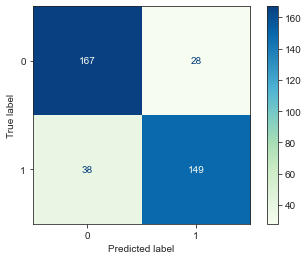

In [62]:
# plot confusion matrix of best model
plot_cm(gs_lr)

- False positive: posts from r/buildapc are wrongly classified as from r/techsupport
- False negative: posts from r/techsupport are wrongly classified as from r/buildapc

As seen from the confusion matrix, there are more false negative counts than false positive counts. This means that there are more posts from r/techsupport being wrongly classified as posts from r/buildapc.

### Model 6: TfidfVectorizer with Logistic Regression
***

In [63]:
pipe_tflr = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

#### Hyper Parameter Tuning using GridSearchCV

In [64]:
pipe_tflr_params = {
    'tf__max_features': [3000, 4000, 5000],
    'tf__stop_words' : [stop_words_set],
    'tf__min_df': [2, 3],
    'tf__max_df': [.9, .95],
    'tf__ngram_range': [(1,2), (2,3)],
    'lr__C': [1.0, 0.5],
    'lr__max_iter': [100, 200]
}

In [65]:
%%time
# GridSearch 
gs_tflr = GridSearchCV(pipe_tflr,
                       param_grid = pipe_tflr_params,
                       cv = 5,
                       n_jobs = 2,
                       scoring = 'accuracy',
                       verbose = 1)

gs_tflr.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Wall time: 1min 27s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=2,
             param_grid={'lr__C': [1.0, 0.5], 'lr__max_iter': [100, 200],
                         'tf__max_df': [0.9, 0.95],
                         'tf__max_features': [3000, 4000, 5000],
                         'tf__min_df': [2, 3],
                         'tf__ngram_range': [(1, 2), (2, 3)],
                         'tf__stop_words': [{' computer', 'a', 'about', 'above',
                                             'after', 'again', 'against', 'ain',
                                             'all', 'am', 'an', 'and', 'any',
                                             'appreciate', 'appreciated',
                                             'appreciates', 'are', 'aren',
                                             "aren't", 'as', 'at', 'be',
                                             'because', 'be

#### Results for TfidfVectorizer with Logistic Regression Model

In [66]:
print_model_scores(gs_tflr)

Model train score: 0.926
Model test score: 0.861
Model best score: 0.834
Model best params: {'lr__C': 1.0, 'lr__max_iter': 100, 'tf__max_df': 0.9, 'tf__max_features': 5000, 'tf__min_df': 2, 'tf__ngram_range': (1, 2), 'tf__stop_words': {"weren't", "needn't", 'then', 'the', 'through', 'up', 'same', 'does', 'at', 'again', 'for', 'you', "won't", 'below', 'under', 'over', 'mustn', 'these', "you'd", 'into', 'she', 'thanks', 'yourself', 'other', 'or', 'he', 'against', 'do', 'above', 'am', "hasn't", 'shouldn', 'its', 'needn', 'isn', 'did', 'not', 'himself', 'those', 'should', 'now', 'too', 'building', 'him', 'build', 'than', 'm', "she's", 'tech', 'with', 'that', "shan't", 'are', 'out', 're', 'couldn', 'we', 'itself', 'own', 'each', 'before', 's', 'ourselves', 'as', 'where', 'by', 'is', 'were', 'which', 'during', "couldn't", "haven't", 'thank', 'an', 'theirs', 'doing', 'in', 'computers', 'further', 'what', 'has', 'so', 'shan', 'why', 'myself', 'pc', 'appreciates', 'been', 'be', 'your', 'once', 

#### Getting the Top 30 words which affect the classification model

In [67]:
lr_coef1 = gs_tflr.best_estimator_['lr'].coef_[0]
lr_names1 = gs_tflr.best_estimator_['tf'].get_feature_names()
lr_coef_df1 = pd.DataFrame(lr_coef1, index = lr_names1, columns = ['coef'])
lr_coef_df1['abs_coef'] = abs(lr_coef_df1['coef'])
lr_coef_plot1 = lr_coef_df1.sort_values(ascending = False, by = 'abs_coef').head(30)
lr_coef_plot1

,coef,abs_coef
laptop,2.715441,2.715441
case,-1.967317,1.967317
issue,1.910583,1.910583
windows,1.864557,1.864557
phone,1.840375,1.840375
tried,1.751314,1.751314
problem,1.683822,1.683822
computer,1.581203,1.581203
motherboard,-1.572317,1.572317
best,-1.520825,1.520825


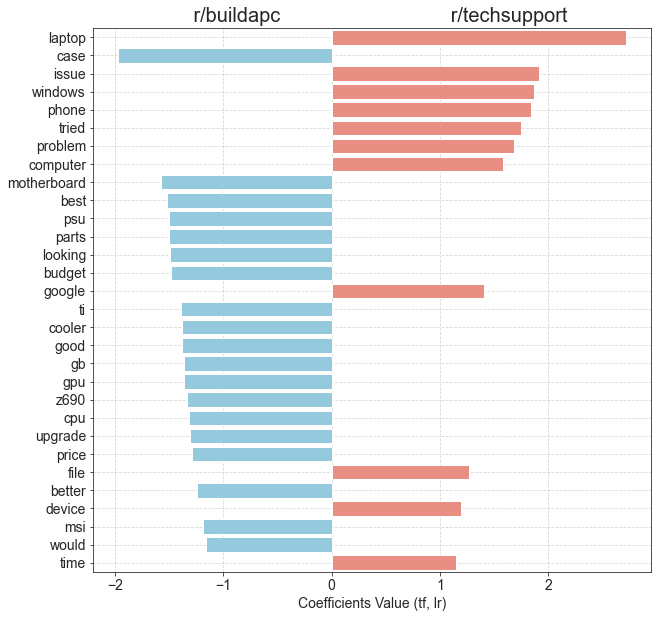

In [68]:
# define a list of colour according to positive or negative values
color_lst = ['skyblue' if float(x) < 0  else 'salmon' for x in lr_coef_plot1['coef']]

# plot barplot
plt.figure(figsize = (10,10))
sns.barplot(x = lr_coef_plot1['coef'],
            y = lr_coef_plot1.index,
            palette = color_lst)
plt.title('   r/buildapc                               r/techsupport', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Coefficients Value (tf, lr)', fontsize = 14)
plt.grid(linestyle = '--', alpha = 0.8);

For the Logisitic Regression coefficients of the top 30 features, it can be seen from the above bar chart for the features in blue correspond to class 0 (r/buildapc) and in light orange correspond to class 1 (r/techsupport). The features do make sense with respect to the relevant subreddits.

Features that correspond to r/buildapc includes:
- `'case'`: PC case
- `'motherboard'`
- `'cpu'`
- `'upgrade'`: where people are asking for upgrading advice
- `'z690'`: the generation of motherboard for 12th gen Intel chips
- `'price'`

Features that correspond to r/techsupport includes:
- `'laptop'` which could be asking for support regarding laptops
- `'windows'` would be referring to support for Windows operating system
- `'issue'` 
- `'tried'` which would be used when people describe what actions have they taken in troubleshooting


#### Confusion Matrix

Classification Performance Metrics
Accuracy   : 0.8613


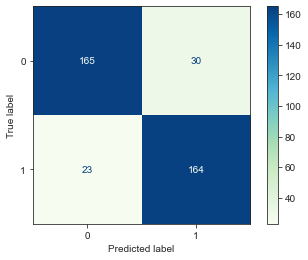

In [69]:
# plot confusion matrix of best model
plot_cm(gs_tflr)

- False positive: posts from r/buildapc are wrongly classified as from r/techsupport
- False negative: posts from r/techsupport are wrongly classified as from r/buildapc

As seen from the confusion matrix, there are slightly more false positive counts than false negative counts. 

## Model Results
***

|            Results from the models            | Train Score | Test Score | Best Score |
|:---------------------------------------------:|:-----------:|:----------:|------------|
| Baseline Accuracy                             |    0.512    |    0.510   |     --     |
| CountVectorizer with Multinomial Naive Bayes  |    0.883    |    0.859   |    0.837   |
| TfidfVectorizer with Multinomial Naive Bayes  |    0.877    |    0.869   |    0.845   |
| CountVectorizer with Random Forest            |    0.872    |    0.838   |    0.827   |
| TfidfVectorizer with Random Forest            |    0.883    |    0.832   |    0.822   |
| CountVectorizer with Logistic Regression      |    0.962    |    0.827   |    0.815   |
| TfidfVectorizer with Logsitic Regression      |    0.926    |    0.861   |    0.834   |

### Observations from the modeling

From the 6 models tested, the best performing model is the **TfidfVectorizer with Multinomial Naive Bayes**. 

The best parameters of the model are as follow:
- 'nb__fit_prior': True
- 'tf__max_df': 0.9
- 'tf__max_features': 3000
- 'tf__min_df': 2
- 'tf__ngram_range': (1, 2)
- 'tf__stop_words': stop_words_set

It has the best test score at 0.869 and best score at 0.845 among the models. This means that the model is able to correctly classify 86.9% of the posts. The small difference between the train and test score also indicate that the model is not overfitted which means it should perform well with unseen data. It can be noted that all the models easily beat the baseline null model.

However, the coefficients of the features from the TfidfVectorizer with Multinomial Naive Bayes model is not very useful for interpretation as the coefficients can only indicate the impact of the features for the classification model and do not identify to a single class. This is unlike Logisitic Regression model where the features can be identified towards one of the two classes. 

Generally, it can be seen that models with TfidfVectorizer generally outperform their CountVectorizer counterpart. This could be that TfidfVectorizer focuses on the frequency of words present in the corpus and also provides the importance of the words. Those words that are less important for analysis can then be removed hence making the model building less complex by reducing the input dimensions. This reduction in the input dimensions can also reduce the chances of overfitting. 

## Conclusion
***

The best model that I should use as a classification model to classify incoming queries into the two categories of queries relating to building a PC or after sales support for the computer purchased from the company would be the TfidfVectorizer with Multinomial Naive Bayes model. With this model performance at 86.9% at classification. There would still be room for improvement to cater for the remaining 13.1% of posts that would be wrongly classified.

### Recommendations
With this model, the company can implement this model as automated first step of classification for incoming queries without need for human oversight as it is able to correctly classify the incoming queries at a high success rate. Subsequently, as the staff reviews the queries and finds out any mistakes, they can transfer the queries across to the correct department while flagging the wrong query for further analysis to improve the model. 

### Limitations
However, there are some limitations to this model which can be improved in the future. 

As there are no access to past queries sent to the company, Reddit posts from the two subreddits (r/buildapc, r/techsupport) were used instead as the training and test dataset to train the model. This might not be ideal as Reddit is a global website with people from all over the globe making posts. The phrasing used in Reddit could be significantly different from the queries the company will receive from local customers here in Singapore. Using the model built from Reddit posts as a start, the company can start to archive and storage all queries sent from the customers to build up a database where local phrasing and nuances can be picked up and incorporated into the model to further tune the model. 

Due to the time constraints, the list of stop words might not be extensive enough to filter out all the words that are not useful to the modeling process hence these stop words can be continually be identified and added to further improve the model.